# Clustering Jerárquico


## Métodos Aglomerativos y Divisivos

### Objetivos del Notebook

1. Comprender los fundamentos del clustering jerárquico y sus diferencias con métodos particionales
2. Implementar y comparar diferentes criterios de enlace (linkage)
3. Construir e interpretar dendrogramas para visualizar jerarquías de clusters
4. Aplicar técnicas de corte del dendrograma para determinar el número de clusters
5. Analizar la complejidad computacional y limitaciones de escalabilidad

---

## 1. Configuración del Entorno

Importamos las bibliotecas necesarias para el desarrollo del módulo.

In [3]:
# Bibliotecas fundamentales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time

# Scipy: clustering jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist, squareform

# Scikit-learn
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


## 2. Fundamentos del Clustering Jerárquico

El clustering jerárquico construye una jerarquía anidada de clusters, representable mediante una estructura de árbol llamada **dendrograma**. A diferencia de K-Means, no requiere especificar el número de clusters a priori.

### 2.1 Generación de Datos de Ejemplo

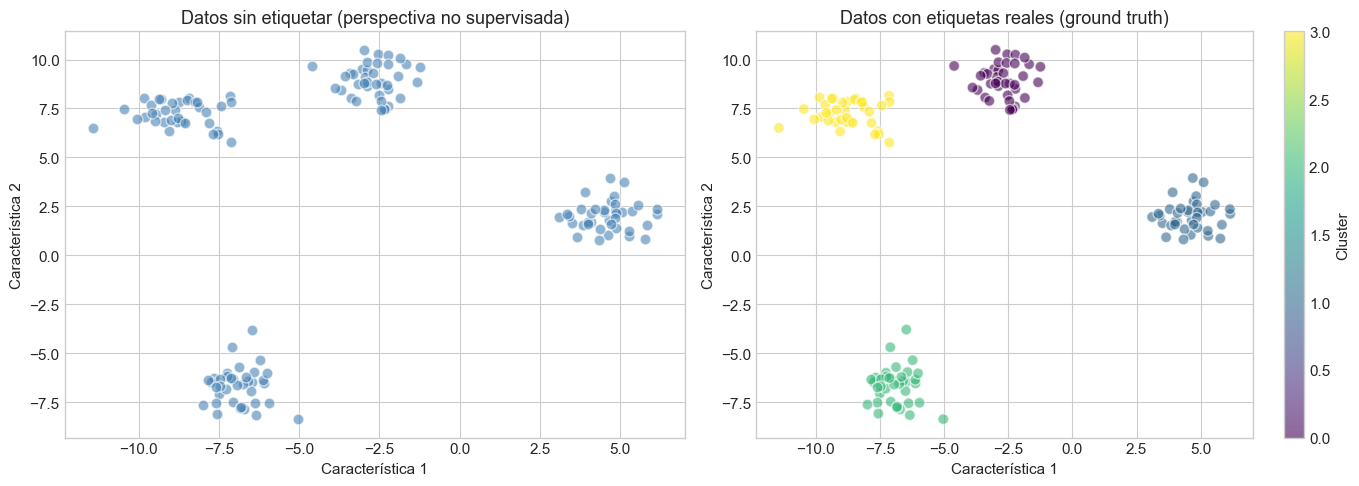

Dimensiones del dataset: (150, 2)
Número de clusters reales: 4


In [4]:
# Generación de datos sintéticos
n_samples = 150
n_clusters_true = 4

X, y_true = make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_clusters_true,
    cluster_std=0.8,
    random_state=RANDOM_STATE
)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X[:, 0], X[:, 1], c='steelblue', alpha=0.6, edgecolors='w', s=60)
axes[0].set_xlabel('Característica 1')
axes[0].set_ylabel('Característica 2')
axes[0].set_title('Datos sin etiquetar (perspectiva no supervisada)')

scatter = axes[1].scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.6, edgecolors='w', s=60)
axes[1].set_xlabel('Característica 1')
axes[1].set_ylabel('Característica 2')
axes[1].set_title('Datos con etiquetas reales (ground truth)')
plt.colorbar(scatter, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print(f"Dimensiones del dataset: {X.shape}")
print(f"Número de clusters reales: {n_clusters_true}")

### 2.2 Matriz de Distancias

El clustering jerárquico opera sobre una matriz de distancias entre todos los pares de observaciones.

Número de distancias únicas (forma condensada): 11175
Fórmula: n(n-1)/2 = 150*149/2 = 11175

Dimensiones matriz cuadrada: (150, 150)


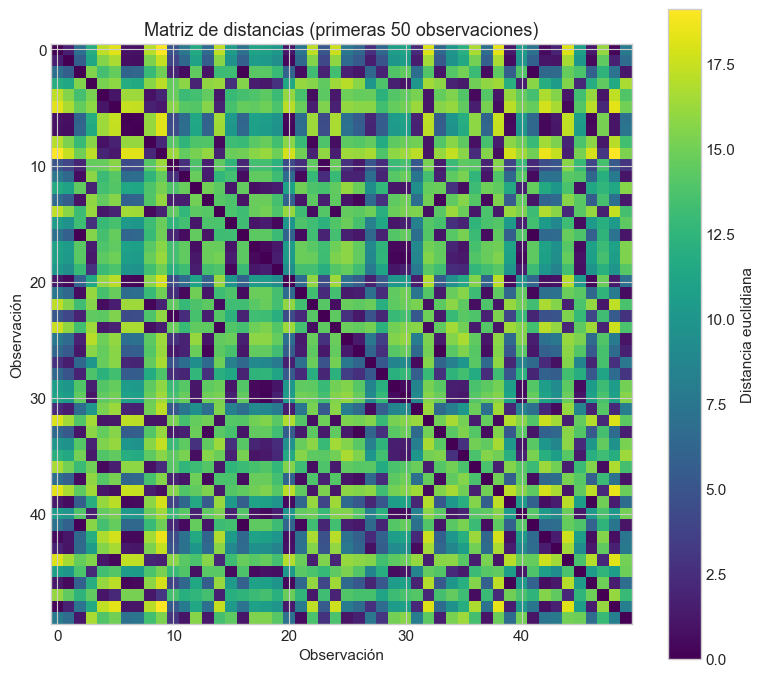

In [5]:
# Calcular matriz de distancias (forma condensada y cuadrada)
distancias_condensadas = pdist(X, metric='euclidean')
matriz_distancias = squareform(distancias_condensadas)

print(f"Número de distancias únicas (forma condensada): {len(distancias_condensadas)}")
print(f"Fórmula: n(n-1)/2 = {n_samples}*{n_samples-1}/2 = {n_samples*(n_samples-1)//2}")
print(f"\nDimensiones matriz cuadrada: {matriz_distancias.shape}")

# Visualización de la matriz de distancias (subconjunto)
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(matriz_distancias[:50, :50], cmap='viridis')
ax.set_xlabel('Observación')
ax.set_ylabel('Observación')
ax.set_title('Matriz de distancias (primeras 50 observaciones)')
plt.colorbar(im, ax=ax, label='Distancia euclidiana')
plt.tight_layout()
plt.show()

## 3. Algoritmo Aglomerativo y Criterios de Enlace

El enfoque aglomerativo (bottom-up) comienza con cada observación como un cluster individual y fusiona iterativamente los clusters más cercanos. El **criterio de enlace** define cómo se calcula la distancia entre clusters.

### 3.1 Implementación con scipy.cluster.hierarchy

In [ ]:
# Calcular linkage con diferentes criterios
metodos_linkage = ['single', 'complete', 'average', 'ward']
resultados_linkage = {}

for metodo in metodos_linkage:
    Z = linkage(X, method=metodo)
    resultados_linkage[metodo] = Z
    print(f"Linkage '{metodo}' calculado. Dimensiones matriz Z: {Z.shape}")

print("\n" + "="*60)
print("La matriz Z tiene (n-1) filas, una por cada fusión.")
print("Columnas: [cluster1, cluster2, distancia, tamaño_nuevo]")

### 3.2 Estructura de la Matriz de Linkage

La matriz Z contiene información sobre cada fusión realizada durante el clustering.

In [ ]:
# Examinar las primeras y últimas fusiones (método Ward)
Z_ward = resultados_linkage['ward']

print("Primeras 5 fusiones (Ward):")
print(f"{'Fusión':<8} {'Cluster A':<12} {'Cluster B':<12} {'Distancia':<12} {'Tamaño':<10}")
print("-" * 54)
for i in range(5):
    print(f"{i+1:<8} {int(Z_ward[i,0]):<12} {int(Z_ward[i,1]):<12} {Z_ward[i,2]:<12.4f} {int(Z_ward[i,3]):<10}")

print("\nÚltimas 5 fusiones (Ward):")
print(f"{'Fusión':<8} {'Cluster A':<12} {'Cluster B':<12} {'Distancia':<12} {'Tamaño':<10}")
print("-" * 54)
for i in range(len(Z_ward)-5, len(Z_ward)):
    print(f"{i+1:<8} {int(Z_ward[i,0]):<12} {int(Z_ward[i,1]):<12} {Z_ward[i,2]:<12.4f} {int(Z_ward[i,3]):<10}")

print(f"\nNota: Índices >= {n_samples} representan clusters formados en fusiones previas.")

### 3.3 Visualización de Dendrogramas

El dendrograma es la representación visual de la jerarquía de clusters.

In [ ]:
# Dendrogramas para cada criterio de enlace
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

titulos = {
    'single': 'Single Linkage (Enlace Simple)',
    'complete': 'Complete Linkage (Enlace Completo)',
    'average': 'Average Linkage (UPGMA)',
    'ward': 'Ward\'s Method'
}

for idx, metodo in enumerate(metodos_linkage):
    ax = axes[idx]
    dendrogram(
        resultados_linkage[metodo],
        ax=ax,
        truncate_mode='lastp',
        p=30,
        leaf_rotation=90,
        leaf_font_size=8,
        show_contracted=True
    )
    ax.set_title(titulos[metodo], fontsize=12, fontweight='bold')
    ax.set_xlabel('Observaciones (o clusters)')
    ax.set_ylabel('Distancia de fusión')

plt.suptitle('Comparación de Dendrogramas por Criterio de Enlace', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 3.4 Análisis de Diferencias entre Criterios

Cada criterio de enlace produce estructuras jerárquicas distintas.

In [ ]:
# Comparar particiones con k=4 para cada criterio
k = 4

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

colores = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for idx, metodo in enumerate(metodos_linkage):
    ax = axes[idx]

    # Obtener asignaciones cortando el dendrograma
    labels = fcluster(resultados_linkage[metodo], k, criterion='maxclust')

    # Calcular silueta y ARI
    sil = silhouette_score(X, labels)
    ari = adjusted_rand_score(y_true, labels)

    # Visualizar
    for cluster_id in range(1, k+1):
        mask = labels == cluster_id
        ax.scatter(X[mask, 0], X[mask, 1], c=colores[cluster_id-1],
                   alpha=0.6, edgecolors='w', s=60, label=f'Cluster {cluster_id}')

    ax.set_title(f"{titulos[metodo]}\nSilueta: {sil:.3f} | ARI: {ari:.3f}", fontsize=11)
    ax.set_xlabel('Característica 1')
    ax.set_ylabel('Característica 2')
    ax.legend(loc='best', fontsize=8)

plt.suptitle(f'Particiones con k={k} clusters según criterio de enlace', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Interpretación del Dendrograma

### 4.1 Lectura de la Altura y Selección del Corte

In [ ]:
# Dendrograma detallado con línea de corte (Ward)
fig, ax = plt.subplots(figsize=(14, 7))

# Generar dendrograma
dend = dendrogram(
    Z_ward,
    ax=ax,
    truncate_mode='lastp',
    p=40,
    leaf_rotation=90,
    leaf_font_size=9,
    show_contracted=True,
    color_threshold=50
)

# Añadir líneas de corte
ax.axhline(y=25, color='green', linestyle='--', linewidth=2, label='Corte para k=4')
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='Corte para k=3')
ax.axhline(y=100, color='orange', linestyle='--', linewidth=2, label='Corte para k=2')

ax.set_title('Dendrograma con líneas de corte (Ward)', fontsize=13, fontweight='bold')
ax.set_xlabel('Observaciones')
ax.set_ylabel('Distancia de fusión')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Interpretación:")
print("- La altura del nodo indica la distancia a la que se fusionan los clusters.")
print("- Ramas verticales largas sugieren clusters bien separados.")
print("- El corte horizontal determina el número de clusters resultantes.")

### 4.2 Análisis de Distancias de Fusión

Identificar saltos en las distancias de fusión ayuda a determinar el número óptimo de clusters.

In [ ]:
# Extraer distancias de fusión
distancias_fusion = Z_ward[:, 2]

# Calcular diferencias entre fusiones consecutivas
diferencias = np.diff(distancias_fusion)

# Identificar los mayores saltos
n_top = 10
indices_mayores_saltos = np.argsort(diferencias)[-n_top:][::-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de distancias de fusión
axes[0].plot(range(1, len(distancias_fusion)+1), distancias_fusion, 'o-', markersize=3, linewidth=1)
axes[0].set_xlabel('Número de fusión')
axes[0].set_ylabel('Distancia de fusión')
axes[0].set_title('Evolución de distancias de fusión')

# Gráfico de diferencias (análogo al método del codo)
# Mostrar desde las últimas 20 fusiones (donde suelen estar los saltos importantes)
ultimas_n = 20
x_axis = range(n_samples - ultimas_n, n_samples)
axes[1].bar(x_axis, diferencias[-ultimas_n:], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Número de fusión')
axes[1].set_ylabel('Incremento en distancia')
axes[1].set_title(f'Diferencias entre fusiones (últimas {ultimas_n})')

# Marcar el mayor salto
max_diff_idx = np.argmax(diferencias[-ultimas_n:])
axes[1].axvline(x=x_axis[max_diff_idx], color='red', linestyle='--',
                label=f'Mayor salto (k={n_samples - x_axis[max_diff_idx] + 1})') # Adjusted k value
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nMayores saltos en distancia de fusión:")
print(f"{'Fusión':<10} {'Diferencia':<15} {'k resultante':<12}")
print("-" * 37)
for idx in indices_mayores_saltos[:5]:
    k_resultante = n_samples - idx - 1
    print(f"{idx+1:<10} {diferencias[idx]:<15.4f} {k_resultante:<12}")

### 4.3 Coeficiente de Correlación Cofenética

Mide qué tan bien el dendrograma preserva las distancias originales entre observaciones.

In [ ]:
# Calcular correlación cofenética para cada método
print("Coeficiente de correlación cofenética por criterio de enlace:")
print("=" * 50)
print(f"{'Criterio':<15} {'Correlación cofenética':<25}")
print("-" * 50)

for metodo in metodos_linkage:
    c, coph_dists = cophenet(resultados_linkage[metodo], distancias_condensadas)
    print(f"{metodo.capitalize():<15} {c:<25.4f}")

print("\nInterpretación:")
print("- Valores cercanos a 1 indican que el dendrograma preserva bien las distancias originales.")
print("- Average linkage típicamente produce la mejor correlación cofenética.")
print("- Ward optimiza varianza, no preservación de distancias.")

## 5. Corte del Dendrograma

### 5.1 Métodos de Corte con fcluster

In [ ]:
# Diferentes criterios de corte
print("Métodos de corte del dendrograma:")
print("=" * 60)

# Por número de clusters
labels_maxclust = fcluster(Z_ward, t=4, criterion='maxclust')
print(f"\n1. criterion='maxclust', t=4")
print(f"   Clusters obtenidos: {len(np.unique(labels_maxclust))}")
print(f"   Distribución: {np.bincount(labels_maxclust)[1:]}")

# Por distancia
labels_distance = fcluster(Z_ward, t=50, criterion='distance')
print(f"\n2. criterion='distance', t=50")
print(f"   Clusters obtenidos: {len(np.unique(labels_distance))}")
print(f"   Distribución: {np.bincount(labels_distance)[1:]}")

# Por inconsistencia
labels_inconsistent = fcluster(Z_ward, t=1.5, criterion='inconsistent', depth=2)
print(f"\n3. criterion='inconsistent', t=1.5, depth=2")
print(f"   Clusters obtenidos: {len(np.unique(labels_inconsistent))}")
print(f"   Distribución: {np.bincount(labels_inconsistent)[1:]}")

### 5.2 Selección Óptima del Número de Clusters

In [ ]:
# Evaluar silueta para diferentes valores de k
k_range = range(2, 11)
siluetas_ward = []
aris_ward = []

for k in k_range:
    labels = fcluster(Z_ward, k, criterion='maxclust')
    siluetas_ward.append(silhouette_score(X, labels))
    aris_ward.append(adjusted_rand_score(y_true, labels))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Silueta
axes[0].plot(k_range, siluetas_ward, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(x=k_range[np.argmax(siluetas_ward)], color='red', linestyle='--',
                label=f'k óptimo = {k_range[np.argmax(siluetas_ward)]}')
axes[0].set_xlabel('Número de clusters (k)')
axes[0].set_ylabel('Coeficiente de Silueta')
axes[0].set_title('Selección de k por Silueta (Ward)')
axes[0].set_xticks(k_range)
axes[0].legend()

# ARI (solo informativo, requiere ground truth)
axes[1].plot(k_range, aris_ward, 'o-', linewidth=2, markersize=8, color='#2ecc71')
axes[1].axvline(x=4, color='red', linestyle='--', label='k real = 4')
axes[1].set_xlabel('Número de clusters (k)')
axes[1].set_ylabel('Adjusted Rand Index')
axes[1].set_title('ARI vs Ground Truth (solo para validación)')
axes[1].set_xticks(k_range)
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Implementación con Scikit-learn

Scikit-learn proporciona `AgglomerativeClustering` para clustering jerárquico.

In [ ]:
# Clustering con AgglomerativeClustering
modelo_ward = AgglomerativeClustering(
    n_clusters=4,
    linkage='ward'
)

labels_sklearn = modelo_ward.fit_predict(X)

# Comparar con scipy
labels_scipy = fcluster(Z_ward, 4, criterion='maxclust') - 1  # Ajustar índice base

# Métricas
sil_sklearn = silhouette_score(X, labels_sklearn)
sil_scipy = silhouette_score(X, labels_scipy)

print("Comparación scipy vs scikit-learn:")
print(f"{'Implementación':<20} {'Silueta':<15}")
print("-" * 35)
print(f"{'scipy.hierarchy':<20} {sil_scipy:<15.4f}")
print(f"{'sklearn':<20} {sil_sklearn:<15.4f}")

# Verificar concordancia
concordancia = adjusted_rand_score(labels_scipy, labels_sklearn)
print(f"\nARI entre ambas implementaciones: {concordancia:.4f}")

In [ ]:
# Comparación de todos los criterios con sklearn
linkages_sklearn = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, linkage_method in enumerate(linkages_sklearn):
    ax = axes[idx]

    modelo = AgglomerativeClustering(n_clusters=4, linkage=linkage_method)
    labels = modelo.fit_predict(X)

    sil = silhouette_score(X, labels)
    ari = adjusted_rand_score(y_true, labels)

    for cluster_id in range(4):
        mask = labels == cluster_id
        ax.scatter(X[mask, 0], X[mask, 1], c=colores[cluster_id],
                   alpha=0.6, edgecolors='w', s=60)

    ax.set_title(f"{linkage_method.capitalize()} Linkage\nSilueta: {sil:.3f} | ARI: {ari:.3f}")
    ax.set_xlabel('Característica 1')
    ax.set_ylabel('Característica 2')

plt.suptitle('Clustering Jerárquico con scikit-learn', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Comportamiento con Diferentes Estructuras de Datos

### 7.1 Clusters No Esféricos

In [ ]:
# Generar datos con forma de lunas
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=RANDOM_STATE)

# Aplicar diferentes criterios de enlace
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Ground truth
axes[0, 0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis',
                   edgecolors='w', s=60)
axes[0, 0].set_title('Ground Truth', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Característica 1')
axes[0, 0].set_ylabel('Característica 2')

# Aplicar cada criterio
for idx, (linkage_method, ax) in enumerate(zip(['single', 'complete', 'average', 'ward'],
                                                [axes[0,1], axes[0,2], axes[1,0], axes[1,1]])):
    modelo = AgglomerativeClustering(n_clusters=2, linkage=linkage_method)
    labels = modelo.fit_predict(X_moons)

    ari = adjusted_rand_score(y_moons, labels)

    ax.scatter(X_moons[:, 0], X_moons[:, 1], c=labels, cmap='viridis',
               edgecolors='w', s=60)
    ax.set_title(f"{linkage_method.capitalize()} (ARI: {ari:.3f})", fontsize=11)
    ax.set_xlabel('Característica 1')
    ax.set_ylabel('Característica 2')

# Ocultar último subplot vacío
axes[1, 2].axis('off')
axes[1, 2].text(0.5, 0.5, 'Single linkage\ndetecta correctamente\nlas formas no convexas',
                ha='center', va='center', fontsize=12, style='italic',
                bbox=dict(boxstyle='round', facecolor='#edf2f7', alpha=0.8))

plt.suptitle('Clustering Jerárquico con Clusters No Esféricos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 7.2 Efecto Cadena (Chaining) en Single Linkage

In [ ]:
# Crear datos que demuestren el efecto cadena
np.random.seed(RANDOM_STATE)

# Dos clusters bien definidos con un "puente" de puntos
cluster1 = np.random.randn(50, 2) * 0.5 + np.array([-3, 0])
cluster2 = np.random.randn(50, 2) * 0.5 + np.array([3, 0])
puente = np.column_stack([np.linspace(-2.5, 2.5, 10), np.random.randn(10) * 0.1])

X_cadena = np.vstack([cluster1, cluster2, puente])
y_cadena = np.array([0]*50 + [1]*50 + [2]*10)  # El puente como "ruido"

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Datos originales
axes[0].scatter(cluster1[:, 0], cluster1[:, 1], c='#3498db', alpha=0.6, edgecolors='w', s=60, label='Cluster 1')
axes[0].scatter(cluster2[:, 0], cluster2[:, 1], c='#e74c3c', alpha=0.6, edgecolors='w', s=60, label='Cluster 2')
axes[0].scatter(puente[:, 0], puente[:, 1], c='#2ecc71', alpha=0.8, edgecolors='w', s=80, marker='s', label='Puente (ruido)')
axes[0].set_title('Datos originales', fontsize=11, fontweight='bold')
axes[0].legend()
axes[0].set_xlabel('Característica 1')
axes[0].set_ylabel('Característica 2')

# Single linkage
modelo_single = AgglomerativeClustering(n_clusters=2, linkage='single')
labels_single = modelo_single.fit_predict(X_cadena)
axes[1].scatter(X_cadena[:, 0], X_cadena[:, 1], c=labels_single, cmap='coolwarm',
                alpha=0.6, edgecolors='w', s=60)
axes[1].set_title(f'Single Linkage (efecto cadena)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Característica 1')
axes[1].set_ylabel('Característica 2')

# Ward
modelo_ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_ward = modelo_ward.fit_predict(X_cadena)
axes[2].scatter(X_cadena[:, 0], X_cadena[:, 1], c=labels_ward, cmap='coolwarm',
                alpha=0.6, edgecolors='w', s=60)
axes[2].set_title(f'Ward (resistente a cadena)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Característica 1')
axes[2].set_ylabel('Característica 2')

plt.tight_layout()
plt.show()

print("El efecto cadena de single linkage hace que los clusters")
print("se fusionen prematuramente cuando existen puntos intermedios.")

## 8. Análisis de Complejidad Computacional

El clustering jerárquico tiene una complejidad temporal de O(n² log n) y espacial de O(n²), lo que limita su aplicabilidad a datasets grandes.

In [ ]:
# Medir tiempo de ejecución para diferentes tamaños de dataset
tamanos = [100, 500, 1000, 2000, 3000, 5000]
tiempos_scipy = []
tiempos_sklearn = []

print("Midiendo tiempos de ejecución...")
print(f"{'n':<10} {'scipy (s)':<15} {'sklearn (s)':<15}")
print("-" * 40)

for n in tamanos:
    X_temp, _ = make_blobs(n_samples=n, n_features=2, centers=4, random_state=RANDOM_STATE)

    # scipy
    inicio = time.time()
    Z_temp = linkage(X_temp, method='ward')
    tiempo_scipy = time.time() - inicio
    tiempos_scipy.append(tiempo_scipy)

    # sklearn
    inicio = time.time()
    modelo = AgglomerativeClustering(n_clusters=4, linkage='ward')
    modelo.fit(X_temp)
    tiempo_sklearn = time.time() - inicio
    tiempos_sklearn.append(tiempo_sklearn)

    print(f"{n:<10} {tiempo_scipy:<15.4f} {tiempo_sklearn:<15.4f}")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(tamanos, tiempos_scipy, 'o-', linewidth=2, markersize=8, label='scipy.hierarchy.linkage')
ax.plot(tamanos, tiempos_sklearn, 's-', linewidth=2, markersize=8, label='sklearn.AgglomerativeClustering')

ax.set_xlabel('Número de observaciones (n)')
ax.set_ylabel('Tiempo de ejecución (segundos)')
ax.set_title('Escalabilidad del Clustering Jerárquico')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNota: Para n > 10,000, considerar métodos alternativos como:")
print("- Mini-Batch K-Means")
print("- BIRCH (pre-clustering)")
print("- Muestreo + clustering jerárquico")

## 9. Caso Práctico: Taxonomía de Productos

Aplicamos clustering jerárquico para crear una taxonomía de productos basada en sus características.

In [ ]:
# Simular datos de productos
np.random.seed(RANDOM_STATE)

# Características de productos
productos = {
    'Producto': [f'P{i:02d}' for i in range(1, 31)],
    'Precio': np.concatenate([
        np.random.uniform(10, 50, 10),      # Económicos
        np.random.uniform(50, 150, 10),     # Gama media
        np.random.uniform(150, 500, 10)     # Premium
    ]),
    'Peso_kg': np.concatenate([
        np.random.uniform(0.1, 1, 10),
        np.random.uniform(1, 5, 10),
        np.random.uniform(5, 20, 10)
    ]),
    'Rating': np.concatenate([
        np.random.uniform(3.0, 4.0, 10),
        np.random.uniform(3.5, 4.5, 10),
        np.random.uniform(4.0, 5.0, 10)
    ]),
    'Ventas_mes': np.concatenate([
        np.random.poisson(500, 10),
        np.random.poisson(200, 10),
        np.random.poisson(50, 10)
    ])
}

df_productos = pd.DataFrame(productos)
print("Dataset de productos:")
print(df_productos.head(10))
print(f"\nDimensiones: {df_productos.shape}")

In [ ]:
# Preprocesamiento
features = ['Precio', 'Peso_kg', 'Rating', 'Ventas_mes']
X_productos = df_productos[features].values

scaler = StandardScaler()
X_productos_scaled = scaler.fit_transform(X_productos)

# Clustering jerárquico
Z_productos = linkage(X_productos_scaled, method='ward')

# Dendrograma con nombres de productos
fig, ax = plt.subplots(figsize=(16, 8))

dendrogram(
    Z_productos,
    ax=ax,
    labels=df_productos['Producto'].values,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=4
)

ax.axhline(y=4, color='red', linestyle='--', linewidth=2, label='Corte sugerido')
ax.set_title('Taxonomía de Productos (Clustering Jerárquico - Ward)', fontsize=13, fontweight='bold')
ax.set_xlabel('Productos')
ax.set_ylabel('Distancia de fusión')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Asignar categorías
df_productos['Categoria'] = fcluster(Z_productos, t=3, criterion='maxclust')

# Perfilar categorías
print("Perfil de categorías de productos:")
print("=" * 70)

for cat in sorted(df_productos['Categoria'].unique()):
    datos_cat = df_productos[df_productos['Categoria'] == cat]
    print(f"\nCategoría {cat} ({len(datos_cat)} productos):")
    print(f"  Precio promedio:  ${datos_cat['Precio'].mean():.2f} (${datos_cat['Precio'].min():.2f} - ${datos_cat['Precio'].max():.2f})")
    print(f"  Peso promedio:    {datos_cat['Peso_kg'].mean():.2f} kg")
    print(f"  Rating promedio:  {datos_cat['Rating'].mean():.2f}")
    print(f"  Ventas promedio:  {datos_cat['Ventas_mes'].mean():.0f} unidades/mes")
    print(f"  Productos:        {', '.join(datos_cat['Producto'].values)}")

In [ ]:
# Visualización de categorías
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colores_cat = ['#e74c3c', '#3498db', '#2ecc71']

# Precio vs Peso
for cat in sorted(df_productos['Categoria'].unique()):
    mask = df_productos['Categoria'] == cat
    axes[0].scatter(df_productos.loc[mask, 'Precio'],
                    df_productos.loc[mask, 'Peso_kg'],
                    c=colores_cat[cat-1], label=f'Categoría {cat}',
                    alpha=0.7, edgecolors='w', s=80)
axes[0].set_xlabel('Precio ($)')
axes[0].set_ylabel('Peso (kg)')
axes[0].set_title('Precio vs Peso')
axes[0].legend()

# Precio vs Ventas
for cat in sorted(df_productos['Categoria'].unique()):
    mask = df_productos['Categoria'] == cat
    axes[1].scatter(df_productos.loc[mask, 'Precio'],
                    df_productos.loc[mask, 'Ventas_mes'],
                    c=colores_cat[cat-1], label=f'Categoría {cat}',
                    alpha=0.7, edgecolors='w', s=80)
axes[1].set_xlabel('Precio ($)')
axes[1].set_ylabel('Ventas mensuales')
axes[1].set_title('Precio vs Ventas')
axes[1].legend()

# Rating vs Ventas
for cat in sorted(df_productos['Categoria'].unique()):
    mask = df_productos['Categoria'] == cat
    axes[2].scatter(df_productos.loc[mask, 'Rating'],
                    df_productos.loc[mask, 'Ventas_mes'],
                    c=colores_cat[cat-1], label=f'Categoría {cat}',
                    alpha=0.7, edgecolors='w', s=80)
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Ventas mensuales')
axes[2].set_title('Rating vs Ventas')
axes[2].legend()

plt.suptitle('Visualización de Categorías de Productos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 10. Resumen y Conclusiones

### Conceptos Clave

1. **Clustering jerárquico** construye una estructura anidada de clusters sin requerir k a priori, visualizable mediante dendrogramas.

2. **Criterios de enlace** determinan cómo se calcula la distancia entre clusters:
   - **Single:** Formas arbitrarias, sensible al efecto cadena.
   - **Complete:** Clusters compactos, control de diámetro.
   - **Average:** Balance intermedio, buena correlación cofenética.
   - **Ward:** Minimiza varianza, similar a K-Means.

3. **Selección del corte:** Analizar saltos en distancias de fusión, usar métricas de validación (silueta), o especificar k directamente.

4. **Escalabilidad:** Limitado a datasets medianos (n < 10,000) debido a complejidad O(n² log n) y memoria O(n²).

### Criterios de Selección

| Situación | Recomendación |
|-----------|---------------|
| Exploración inicial | Ward o Average |
| Clusters elongados | Single linkage |
| Control de tamaño | Complete linkage |
| Dataset grande (n > 10k) | K-Means o BIRCH |
| Taxonomías/filogenias | Average (UPGMA) |

---

## Referencias

- Johnson, S. C. (1967). Hierarchical clustering schemes. *Psychometrika*, 32(3), 241-254.
- Ward Jr, J. H. (1963). Hierarchical grouping to optimize an objective function. *Journal of the American Statistical Association*, 58(301), 236-244.
- Sokal, R. R., & Michener, C. D. (1958). A statistical method for evaluating systematic relationships. *University of Kansas Science Bulletin*, 38, 1409-1438.
- Scipy documentation: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
- Scikit-learn documentation: https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

---


# EOF (End Of File)